# CIS680: Project 2: YOLO
### Due:
* Part (a) Sept. 30 at 11:59 p.m.
* Part (b) Oct. 7 at 11:59 p.m.

### Instructions:
* Part (a) consists of parts 1-4, and is due on September 30 at 11:59 p.m. EDT.
* Part (b) consists of part 5-8 and is due on October 7 at 11:59 p.m. EDT
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Initialization

In [39]:
if 'google.colab' in str(get_ipython()):
    # Colab specific setup
    assignment_path = '/content/gdrive/My Drive/Colab Notebooks/CIS 680/HW2/'
    
    # Mount your drive
    from google.colab import drive
    drive.mount("/content/gdrive")
    
    # Setup assignment folder and switch
    import os
    os.makedirs(assignment_path, exist_ok=True)
    os.chdir(assignment_path)
    
    # Only download files once
    if not os.path.isdir('tests'):
        !gdown --id 1QxzpuZoca68S-ZCfdqyWph7a-tfwa1az
        !unzip -u hw2_additional_files.zip && rm hw2_additional_files.zip
        
    !pip install otter-grader pytorch_lightning &> /dev/null
    
notebook_name = 'hari_cis680_hw2.ipynb'
import otter
grader = otter.Notebook(notebook_name)
grader._colab = False

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Code

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import itertools
from sklearn import metrics
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);
np.set_printoptions(precision=6)
torch.set_printoptions(precision=6)

In [41]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data('images.npz')
raw_labels = load_data('labels.npz')

In [42]:
# DEFINED VISUALIZATION FUNCTION
def visualize_output(image, label, title):
  label = torch.unsqueeze(label, 0)
  label = np.array(label.cpu())

  # draw reconstruction
  reconstructed_label = reconstruct_raw_labels(label, img_dim=128)

  r_label = reconstructed_label.astype(int)[0]
  img_reconstruct = torch.permute(image, (1,2,0))
  img_reconstruct = np.array(img_reconstruct.cpu(), dtype='uint8').copy()

  # draw bounding boxes
  for label in r_label:
    if label[0] == 0:
      cv2.rectangle(img_reconstruct, (label[1], label[2]), (label[3], label[4]), (255,0,0), 1)
    elif label[0] == 1:
      cv2.rectangle(img_reconstruct, (label[1], label[2]), (label[3], label[4]), (0,0,255), 1)
    elif label[0] == 2:
      cv2.rectangle(img_reconstruct, (label[1], label[2]), (label[3], label[4]), (0,255,0), 1)
  plt.imshow(img_reconstruct)
  plt.title(title)
  plt.show()

In [43]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
    # set values
    img_dim = 128
    grid_size = 16
    labels = []
    # loop through raw labels
    for i in range(len(raw_labels)):
      label_one = np.zeros((8, 8, 8))
      raw_one = raw_labels[i]             
      # 1. Extract the x1, y1, x2, y2 values
      x1, y1, x2, y2 = raw_one[:, 1], raw_one[:, 2], raw_one[:, 3], raw_one[:, 4]
    
      # Find center of bounding boxes
      bb_center_x = 0.5 * (x1+x2)
      bb_center_y = 0.5 * (y1+y2)

      # Find the index of the grid in which the center of the bounding box lies
      grid_idx_x = np.floor(bb_center_x / grid_size).astype(int)
      grid_idx_y = np.floor(bb_center_y / grid_size).astype(int)

      # Set the Pr(objectness) == 1 at the grid cell where the bounding box lies
      label_one[0, grid_idx_y, grid_idx_x] = 1

      # (2) Find x, y
      """
      x, y is the center of the bounding box relative to the bounds of the grid cell
      """
      x = (bb_center_x - grid_idx_x * grid_size) / grid_size
      y = (bb_center_y - grid_idx_y * grid_size) / grid_size

      label_one[1, grid_idx_y, grid_idx_x] = x
      label_one[2, grid_idx_y, grid_idx_x] = y
      
      # (3) Find w, h
      """
      w, h is the width and height relative to the image width and height
      """
      w = (x2 - x1) / img_dim 
      h = (y2 - y1) / img_dim 

      label_one[3, grid_idx_y, grid_idx_x] = w
      label_one[4, grid_idx_y, grid_idx_x] = h

      # (4) One hot encoding for Pr(Pedestrian), Pr(Traffic Light), Pr(Car), labels[5:7, :, :]
      #classes_all = np.zeros((8,8))
      classes = raw_one[:, 0]
      classes_grid = np.zeros((8,8)) - 1
      classes_grid[grid_idx_y, grid_idx_x] = classes
      
      #true_label_idx = (raw_one[:,0] + 5).astype(int)
      true_label_idx = (classes_grid[grid_idx_y, grid_idx_x] + 5).astype(int)
      label_one[true_label_idx, grid_idx_y, grid_idx_x] = 1

      # fill for all images
      labels.append(label_one)
    
    return np.asarray(labels)

In [44]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
    grid_size = 16

    raw_labels = []
    for i in range(len(labels)):    
      label_one = labels[i]
      # find what box corresponds to a grid cell
      objectness = label_one[0]
      grid_idx_y, grid_idx_x = np.nonzero(objectness)

      # raw label
      raw_label_one = np.zeros((len(grid_idx_x), 5))
      
      # find the x,y center location of box
      x, y = label_one[1, grid_idx_y, grid_idx_x], label_one[2, grid_idx_y, grid_idx_x]
      center_x, center_y = 16 * grid_idx_x + 16 * x,  16 * grid_idx_y + 16 * y

      # find width of anchor box
      width = label_one[3, grid_idx_y, grid_idx_x] * img_dim
      height = label_one[4, grid_idx_y, grid_idx_x] * img_dim
      
      # extract x1, y1, x2, y2
      x1 = center_x - width/2
      x2 = center_x + width/2
      y1 = center_y - height/2
      y2 = center_y + height/2
      raw_label_one[:,1] = x1
      raw_label_one[:,2] = y1
      raw_label_one[:,3] = x2
      raw_label_one[:,4] = y2

      # find the correct class
      class_matrix = label_one[5:8, grid_idx_y, grid_idx_x]
      classes_0 = np.logical_and((class_matrix[0] > class_matrix[1]),(class_matrix[0] > class_matrix[2]))
      classes_1 = np.logical_and((class_matrix[1] > class_matrix[0]),(class_matrix[1] > class_matrix[2]))
      classes_2 = np.logical_and((class_matrix[2] > class_matrix[0]),(class_matrix[2] > class_matrix[1]))
      
      classes = np.zeros(len(classes_0))
      classes[classes_0] = 0
      classes[classes_1] = 1
      classes[classes_2] = 2

      raw_label_one[:, 0] = classes
      raw_labels.append(raw_label_one)

    return np.array(raw_labels, dtype='object')

In [45]:
def intersection_over_union(prediction, ground_truth):

    x1 = torch.max((prediction[:,0] - prediction[:,2]/2), (ground_truth[:,0] - ground_truth[:,2]/2))
    y1 = torch.max((prediction[:,1] - prediction[:,3]/2), (ground_truth[:,1] - ground_truth[:,3]/2))
    x2 = torch.min((prediction[:,0] + prediction[:,2]/2), (ground_truth[:,0] + ground_truth[:,2]/2))
    y2 = torch.min((prediction[:,1] + prediction[:,3]/2), (ground_truth[:,1] + ground_truth[:,3]/2))

    intersection = ((x2 - x1)).clamp(min=0) * ((y2 - y1)).clamp(min=0) 
    box1_area = abs(prediction[:,2]*prediction[:,3])
    box2_area = abs(ground_truth[:,2]*ground_truth[:,3])
    union = box1_area + box2_area - intersection + 1e-6
    return intersection / union

In [46]:
## We can calculate the IOU more compactly
def yolo_loss(output, target):
    """
    output : batch_size x 8 x 8 x 8 : ((Pr(obj),x,y,w,h,Pr(pedestrian),Pr(traffi light),Pr(car)), grid_idx_x, grid_idx_y)
    target : batch_size x 8 x 8 x 8 : ((Pr(obj),x,y,w,h,Pr(pedestrian),Pr(traffi light),Pr(car)), grid_idx_x, grid_idx_y)
    """
    grid_size = 16
    img_dim = 128.0
    lambda_coord = 5
    lambda_noobj = 0.5

    # Intitialize losses to int, tensor does not work, is_leaf error!
    loss_xy = 0
    loss_wh = 0
    loss_obj = 0
    loss_noobj = 0
    loss_class = 0
    
    # Equivalent to 1obj_ij function, is True wherever Pr(objt) is 1
    obj_ij = target[:, 0, :, :].nonzero() # (what image in batch, x, y)

    # Location loss 
    # xy loss---------------------------------------------#
    x = output[obj_ij[:,0], 1, obj_ij[:, 1], obj_ij[:, 2]]
    x_hat = target[obj_ij[:,0], 1, obj_ij[:, 1], obj_ij[:, 2]]

    y = output[obj_ij[:,0], 2, obj_ij[:, 1], obj_ij[:, 2]]
    y_hat = target[obj_ij[:,0], 2, obj_ij[:, 1], obj_ij[:, 2]]
    loss_xy = torch.sum((x - x_hat)**2 + (y - y_hat)**2)

    # wh loss--------------------------------------------#
    w = output[obj_ij[:,0], 3, obj_ij[:, 1], obj_ij[:, 2]]
    w_hat = target[obj_ij[:,0], 3, obj_ij[:, 1], obj_ij[:, 2]]

    h = output[obj_ij[:,0], 4, obj_ij[:, 1], obj_ij[:, 2]]
    h_hat = target[obj_ij[:,0], 4, obj_ij[:, 1], obj_ij[:, 2]]

    # using sqrt, can also use log instead to regularize
    loss_wh = torch.sum((torch.sqrt(w) - torch.sqrt(w_hat))**2 + (torch.sqrt(h) - torch.sqrt(h_hat))**2)

    # Confidence Loss
    # extract iou --------------------------------------------#

    # TARGET
    x_scale_target = grid_size * x + grid_size * obj_ij[:,1]
    y_scale_target = grid_size * y + grid_size * obj_ij[:,2]
    w_scale_target, h_scale_target = img_dim * w, img_dim * h

    # PREDICTED
    x_scale_pred = grid_size * x_hat + grid_size * obj_ij[:,1]
    y_scale_pred = grid_size * y_hat + grid_size * obj_ij[:,2]
    w_scale_pred, h_scale_pred = img_dim * w_hat, img_dim * h_hat

    # stack them
    pred_iou = torch.stack((x_scale_pred, y_scale_pred, w_scale_pred, h_scale_pred), dim=1)
    target_iou = torch.stack([x_scale_target, y_scale_target, w_scale_target, h_scale_target], dim=1)
    
    # obj loss ----------------------------------------------#
    C_hat = intersection_over_union(pred_iou,target_iou)
    C = output[obj_ij[:, 0], 0, obj_ij[:,1], obj_ij[:, 2]]
    loss_obj = torch.sum((C - C_hat)**2)

    # noobj loss ----------------------------------------------#
    noobj_ij = (target[:, 0, :, :] == 0).nonzero()

    #print((output[noobj_ij[:,0], 0, noobj_ij[:,1], noobj_ij[:,2]]))
    loss_noobj = torch.sum((output[noobj_ij[:,0], 0, noobj_ij[:,1], noobj_ij[:,2]])**2)

    # Classification Loss ----------------------------------------------#
    p_c = target[obj_ij[:,0], 5:8, obj_ij[:,1], obj_ij[:, 2]]
    p_hat_c = output[obj_ij[:,0], 5:8, obj_ij[:,1], obj_ij[:, 2]]
    loss_class = torch.sum((p_c - p_hat_c)**2) 

    # Total loss
    loss = lambda_coord * (loss_xy + loss_wh) + loss_obj + lambda_noobj * loss_noobj + loss_class
    return loss

In [47]:
class YOLO(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1)
        self.transposed_conv7 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.transposed_conv8 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv9 = nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, padding=1)

        self.batch1 = nn.BatchNorm2d(num_features=32)
        self.batch2 = nn.BatchNorm2d(num_features=64)
        self.batch3 = nn.BatchNorm2d(num_features=128)
        self.batch4 = nn.BatchNorm2d(num_features=256)
        self.batch5 = nn.BatchNorm2d(num_features=512)
        self.batch6 = nn.BatchNorm2d(num_features=1024)
        self.batch7 = nn.BatchNorm2d(num_features=256)
        self.batch8 = nn.BatchNorm2d(num_features=64)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batch1(self.conv1(x)))
        x = self.relu(self.batch2(self.conv2(x)))
        x = self.relu(self.batch3(self.conv3(x)))
        x = self.relu(self.batch4(self.conv4(x)))
        x = self.relu(self.batch5(self.conv5(x)))
        x = self.relu(self.batch6(self.conv6(x)))
        x = self.relu(self.batch7(self.transposed_conv7(x)))
        x = self.relu(self.batch8(self.transposed_conv8(x)))
        x = self.conv9(x)
        x = torch.sigmoid(x)
        return x

    def training_step(self, batch, batch_idx):
        data, targets = batch
        predictions = model(data)
        loss = yolo_loss(predictions, targets)

        self.log('loss', loss)

        return {'loss': loss, 'outputs': predictions, 'targets': targets}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        outputs_train = torch.cat([x['outputs'] for x in outputs])
        outputs_train = low_confidence_suppression(outputs_train)
        outputs_train = non_max_suppression(outputs_train)

        targets_train = torch.cat([y['targets'] for y in outputs])
        
        map_train = mean_average_precision(outputs_train, targets_train)
        print("TRAIN MAP ", map_train)

        train_map.append(map_train)
        train_loss.append(avg_loss)

    def validation_step(self, batch, batch_idx):
        data, targets = batch
        outputs = model(data)
        loss = yolo_loss(outputs, targets)

        self.log('val_loss', loss)
        
        return {'val_loss': loss, 'outputs': outputs, 'targets': targets}

    def validation_epoch_end(self, outputs):
        loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      
        outputs_val = torch.cat([x['outputs'] for x in outputs])
        outputs_val = low_confidence_suppression(outputs_val)
        outputs_val = non_max_suppression(outputs_val)
        targets_val = torch.cat([y['targets'] for y in outputs])
        map_val = mean_average_precision(outputs_val, targets_val)
        self.log('val_map', map_val)
        validation_map.append(map_val)
        print("VAL MAP ", map_val)
        
        validation_loss.append(loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=10e-4, weight_decay=0.0005)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[90], gamma=0.1)
        return (
            {"optimizer": optimizer,"lr_scheduler": scheduler},
        )


In [140]:
def low_confidence_suppression(label):
    low_conf_threshold = 0.6
    low_conf_indices = (label[:, 0, :, :] < low_conf_threshold).nonzero()

    label_confidence_suppression = label.clone()
    label_confidence_suppression[low_conf_indices[:, 0], :, low_conf_indices[:, 1], low_conf_indices[:, 2]] = 0   
    return label_confidence_suppression

def non_max_suppression(label):
    # label : batch_size x 8 x 8 x 8
    label_nms = label.clone()
    num_classes = 3
    batch_size = len(label)
    grid_size = 16
    img_dim = 128
    
    # Find indices where there exist bounding boxes as predicted by the network
    for i in range(batch_size):
        predicted_indices = (label_nms[i, 0, :, :] != 0).nonzero()

    # The above returns all bounding boxes for a single image
    # Separate the bounding boxes into the different classes
        for c in range(num_classes):
            class_idx = [x for x in range(len(predicted_indices)) if torch.argmax(label_nms[i, 5:, predicted_indices[x, 0], predicted_indices[x, 1]]) == c]

            if len(class_idx) == 0:
              continue
              
            # Compute bounding boxes for the indices   
            x = label_nms[i, 1, predicted_indices[class_idx, 0], predicted_indices[class_idx, 1]] *  grid_size + predicted_indices[class_idx, 1] * grid_size
            y = label_nms[i, 2, predicted_indices[class_idx, 0], predicted_indices[class_idx, 1]] *  grid_size + predicted_indices[class_idx, 0] * grid_size
            w = label_nms[i, 3, predicted_indices[class_idx, 0], predicted_indices[class_idx, 1]] *  img_dim
            h = label_nms[i, 4, predicted_indices[class_idx, 0], predicted_indices[class_idx, 1]] *  img_dim

            bb_detected = torch.stack((x ,y ,w ,h), dim=1)
            #print(f'The detected bounding boxes are :{bb_detected}')
            
            # Sort bounding boxes by largest class probability (also try class probability)
            sorted_idx = torch.argsort(label_nms[i, c, predicted_indices[class_idx, 0], predicted_indices[class_idx, 1]], dim=0, descending=True)
            sorted_idx = sorted_idx.tolist()

            #print(f'The sorted index is : {sorted_idx.type}')
            s_max = sorted_idx[0]
            highest_bb = bb_detected[s_max]
            retain_idx = []
            retain_idx.append(s_max) # place highest confidence in retain_idx

            # Compute IOU for highest probability box against all other anchor boxes and retain if iou < 0.5
            for s in sorted_idx:
                box = bb_detected[s]
                valid_boxes = bb_detected[retain_idx]

                box_keep = True
                for v in valid_boxes:
                  iou = intersection_over_union(torch.unsqueeze(box, dim=0), torch.unsqueeze(v, dim=0))
                  if iou > 0.5:
                    box_keep = False
                
                if box_keep and s not in retain_idx:
                  retain_idx.append(s)

            #print(f'Retained bounding box:{retain_idx}')
            
            suppressed_idx = [s for s in sorted_idx if s not in retain_idx]
            idx_to_remove = (np.array(class_idx)[suppressed_idx]).tolist()
            #print(idx_to_remove)
            #print(f'The suppressed indices are:{suppressed_idx}')
            # Set the suppresed values to zero
            label_nms[i, :, predicted_indices[idx_to_remove, 0], predicted_indices[idx_to_remove, 1]] = 0

    return label_nms

In [68]:
def iou_precision_recall(pred_obj, predictions, targets):
  img_dim =128
  grid_size =16
  

  pred_boxes = predictions[1:5]
  target_boxes = targets[1:5]

  pred_boxes[0] = grid_size * pred_boxes[0] + grid_size * pred_obj[2]
  pred_boxes[1] = grid_size * pred_boxes[1] + grid_size * pred_obj[1]
  pred_boxes[2] = img_dim * pred_boxes[2]
  pred_boxes[3] = img_dim * pred_boxes[3]

  # Target xywh
  target_boxes[0] = grid_size * target_boxes[0] + grid_size * pred_obj[2]
  target_boxes[1] = grid_size * target_boxes[1] + grid_size * pred_obj[1]
  target_boxes[2] = img_dim * target_boxes[2]
  target_boxes[3] = img_dim * target_boxes[3]

  # iou
  #print(type(target_boxes))
  pred_boxes = torch.unsqueeze(pred_boxes, dim=0)
  target_boxes = torch.unsqueeze(target_boxes, dim=0)
  #print(pred_boxes.shape)
  iou = intersection_over_union(pred_boxes, target_boxes)

  return iou

def precision_recall_curve(predictions, targets, target_class):

    threshold = np.linspace(0.0, 1.00, num=25)

    # extract predictions and corresponding probability confidences
    pred_obj = predictions[:,0,:,:].nonzero()

    pred_probs, pred_classes = torch.max(predictions[pred_obj[:, 0], 5:8, pred_obj[:,1], pred_obj[:,2]], dim=1)

    # make sure predictions are for this target class
    pred_obj = pred_obj[pred_classes == target_class]
    pred_probs = pred_probs[pred_classes == target_class]
    pred_classes = pred_classes[pred_classes == target_class]

    # sort probabilities of predictions
    sorted_scores, sorted_indices = torch.sort(pred_probs, descending=True)
    pred_obj= pred_obj[sorted_indices]
    pred_probs = pred_probs[sorted_indices]
    pred_classes = pred_classes[sorted_indices]

    # target classes 
    target_probs, target_classes = torch.max(targets[pred_obj[:, 0], 5:8, pred_obj[:,1], pred_obj[:,2]], dim=1)

    # ground truths
    target_obj = targets[:,0,:,:].nonzero()
    _, target_classes_full = torch.max(targets[target_obj[:, 0], 5:8, target_obj[:,1], target_obj[:,2]], dim=1)
    target_classes_full = target_classes_full[target_classes_full == target_class]
    

    # iterate through a set thresholds for calculating the precision with recall thresholds
    tp = 0
    fp = 0
    gt = len(target_classes_full)

    threshold_idx = 0
    recall = []
    precision = []
    for i in range(len(pred_obj)):
      pred = predictions[pred_obj[i][0], :, pred_obj[i][1], pred_obj[i][2]]
      ground_truth = targets[pred_obj[i][0], :, pred_obj[i][1], pred_obj[i][2]]

      iou = iou_precision_recall(pred_obj[i], pred, ground_truth)
      if iou > 0.5 and pred_classes[i] == target_classes[i]:
        tp += 1
      else:
        fp += 1

      p = tp/(tp + fp)
      r = tp/gt

      if r >= threshold[threshold_idx]:
        recall.append(r)
        precision.append(p)
        threshold_idx+=1

    return recall, precision

def average_precision(predictions, targets, target_class):
    recall, precision = precision_recall_curve(predictions, targets, target_class)
    if len(recall) < 2 or len(precision) < 2:
      return 0 
    else:
      average_precision = metrics.auc(recall, precision)
    
    return average_precision

def mean_average_precision(predictions, targets):
    class_0 = average_precision(predictions, targets, 0)
    class_1 = average_precision(predictions, targets, 1)
    class_2 = average_precision(predictions, targets, 2)

    mean_average_precision = (class_0 + class_1 + class_2)/3
    return mean_average_precision

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light.
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

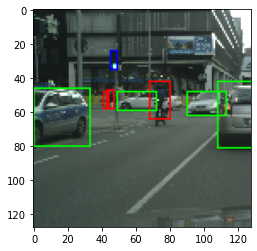

In [50]:
# Show the chosen image with ground truth bounding boxes visualized.
# classes - pedestrian, traffic light, car 
import cv2

chosen_img_index = 8
img = images[chosen_img_index].copy()  
labels = raw_labels[chosen_img_index].astype(int)
for label in labels:
  if label[0] == 0:
    cv2.rectangle(img, (label[1], label[2]), (label[3], label[4]), (255,0,0), 1)
  elif label[0] == 1:
    cv2.rectangle(img, (label[1], label[2]), (label[3], label[4]), (0,0,255), 1)
  elif label[0] == 2:
    cv2.rectangle(img, (label[1], label[2]), (label[3], label[4]), (0,255,0), 1)
plt.imshow(img)
plt.show()


<!-- BEGIN QUESTION -->



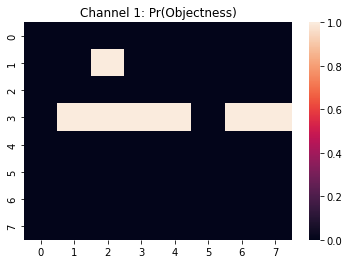

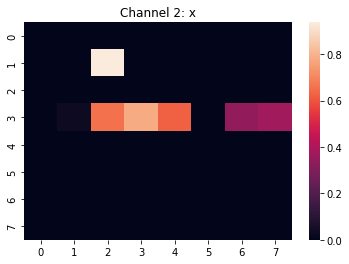

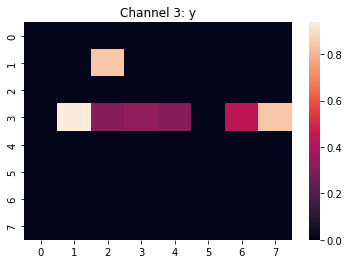

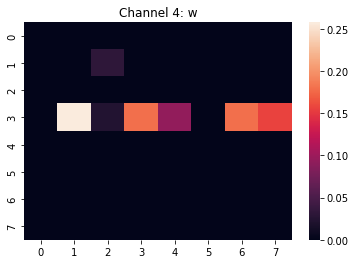

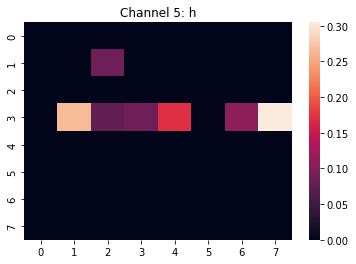

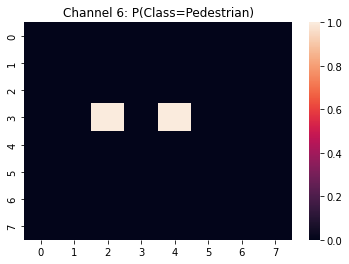

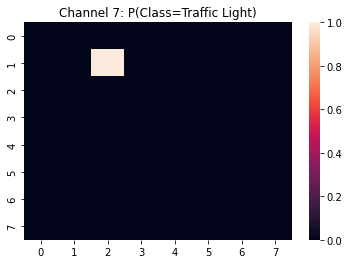

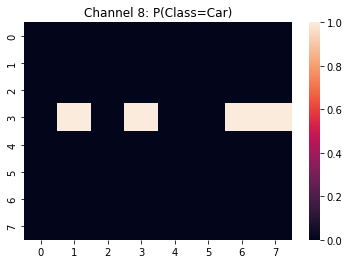

In [51]:
# Visualize the 8x8x8 representation.
import seaborn as sns
processed_label = process_labels(np.array([raw_labels[chosen_img_index]]))
processed_label_dim = processed_label[0]
list_names = ['Channel 1: Pr(Objectness)', 'Channel 2: x', 'Channel 3: y', 'Channel 4: w', 'Channel 5: h', 'Channel 6: P(Class=Pedestrian)', 'Channel 7: P(Class=Traffic Light)', 'Channel 8: P(Class=Car)']
for i in range(processed_label_dim.shape[0]):
  sns.heatmap(processed_label_dim[i]).set(title=list_names[i])
  plt.show()

In [14]:
#grader.check("q1b")

<!-- END QUESTION -->



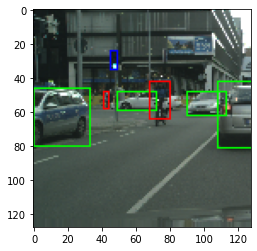

In [52]:
# Convert back to the original representation (test cases below should pass).
reconstructed_label = reconstruct_raw_labels(processed_label, img_dim=128)

r_label = reconstructed_label.astype(int)[0]
img_reconstruct = images[chosen_img_index].copy()
for label in r_label:
  if label[0] == 0:
    cv2.rectangle(img_reconstruct, (label[1], label[2]), (label[3], label[4]), (255,0,0), 1)
  elif label[0] == 1:
    cv2.rectangle(img_reconstruct, (label[1], label[2]), (label[3], label[4]), (0,0,255), 1)
  elif label[0] == 2:
    cv2.rectangle(img_reconstruct, (label[1], label[2]), (label[3], label[4]), (0,255,0), 1)
plt.imshow(img_reconstruct)
plt.show()

In [53]:
grader.check("q1c")

q1c results: All test cases passed!

2. Implement the loss function. (3%)

In [54]:
grader.check("q2")

q2 results: All test cases passed!

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

**Yolo model architecture**

Below we show our model architecture. Each layer has a text box below it that illustrates what type of kernel was applied to it, followed by the batch normalization and RELU layers. The last layer is a sigmoid layer that is applied to the full output of the conv9 layer. 

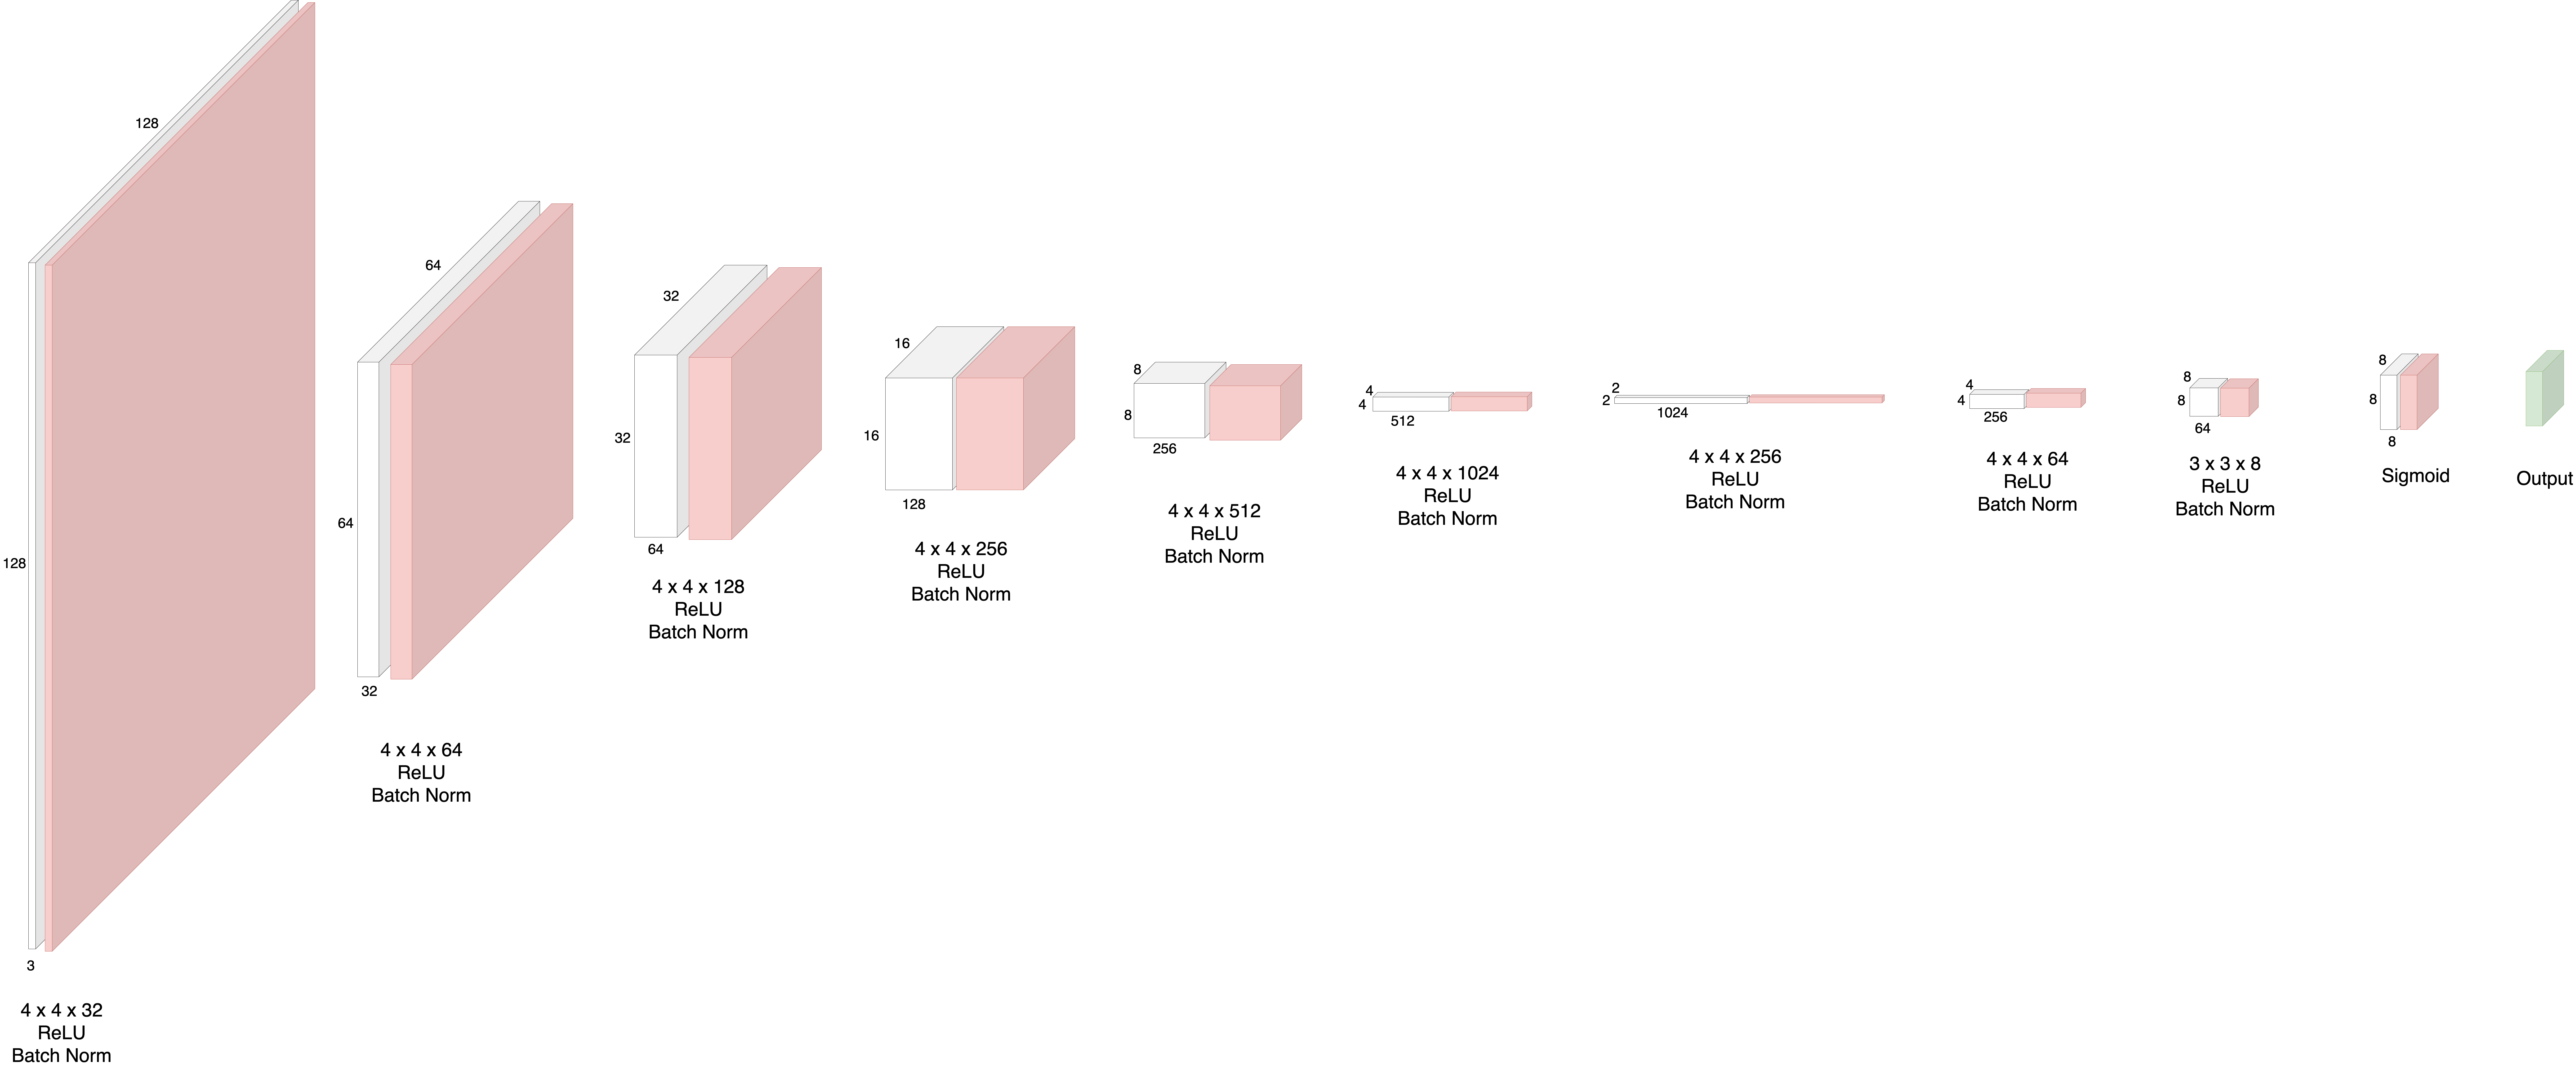

**Flowchart of Training Pipeline**

Below is the flowchart. Each block illustrates the goal of what we planned to achieve with each function listed blue. 

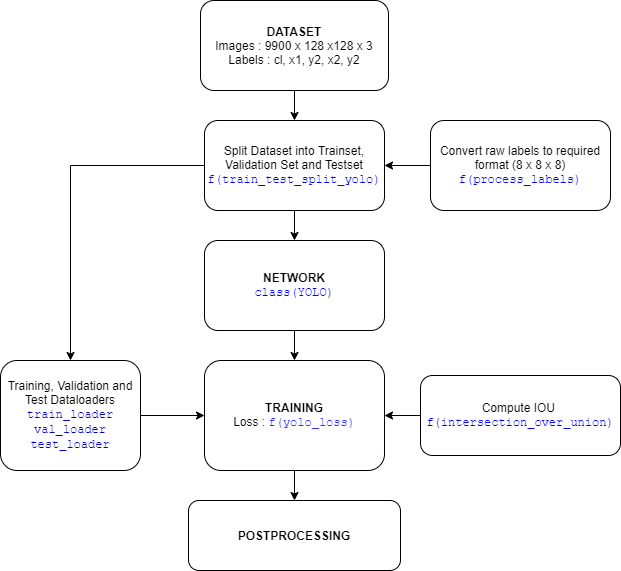

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

In [18]:
def train_test_split_yolo(images, labels, split_ratio=4/5):
 
    train_split = int(split_ratio * images.shape[0])
    print('No. of images in train split', train_split)
    # Process raw labels into required (8 x 8 x 8) format
    #processed_labels = process_labels(labels)
    
    train_images, train_labels, test_images, test_labels = images[:train_split],labels[:train_split],images[train_split:],labels[train_split:]
    train_labels = process_labels(train_labels)
    test_labels = process_labels(test_labels)
  
    train_images, test_images = train_images.transpose(0, 3, 1, 2), test_images.transpose(0, 3, 1, 2)
    train_images, train_labels = torch.tensor(train_images, dtype=torch.float), torch.tensor(train_labels, dtype=torch.float)
    test_images, test_labels = torch.tensor(test_images, dtype=torch.float), torch.tensor(test_labels, dtype=torch.float)

    print(f'Shapes of the images are :{train_images.shape} and {test_images.shape}')

    # validation split
    val_split = int(train_split * 0.1)
    train_num = train_split - val_split
    train_images_cv, train_labels_cv, validation_images, validation_labels = train_images[:train_num],train_labels[:train_num],train_images[train_num:],train_labels[train_num:]

    print(f'Shapes of the images are :{validation_images.shape} and {train_images_cv.shape}')

    return train_images_cv, train_labels_cv, test_images, test_labels, validation_images, validation_labels

train_images, train_labels, test_images, test_labels, validation_images, validation_labels = train_test_split_yolo(images=images, labels=raw_labels)

No. of images in train split 7920
Shapes of the images are :torch.Size([7920, 3, 128, 128]) and torch.Size([1980, 3, 128, 128])
Shapes of the images are :torch.Size([792, 3, 128, 128]) and torch.Size([7128, 3, 128, 128])


In [19]:
# Setup your training

# Build train and test loader
trainset = torch.utils.data.TensorDataset(train_images, train_labels)
valset = torch.utils.data.TensorDataset(validation_images, validation_labels)
testset = torch.utils.data.TensorDataset(test_images, test_labels)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

%load_ext tensorboard

In [20]:
# Train your model
## TRAINING_CODE
model = YOLO().to(device)
train_loss=[]
validation_loss = []
train_map = []
validation_map = []


tb_logger = pl_loggers.TensorBoardLogger('/content/gdrive/MyDrive/Colab Notebooks/CIS 680/HW2/lightning_logs')
checkpoint_callback = pl_callbacks.ModelCheckpoint()
trainer = pl.Trainer(gpus=1,progress_bar_refresh_rate=20, max_epochs=150, callbacks=[checkpoint_callback, EarlyStopping(monitor="val_map", patience=40)])
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type            | Params
------------------------------------------------------
0  | conv1            | Conv2d          | 1.6 K 
1  | conv2            | Conv2d          | 32.8 K
2  | conv3            | Conv2d          | 131 K 
3  | conv4            | Conv2d          | 524 K 
4  | conv5            | Conv2d          | 2.1 M 
5  | conv6            | Conv2d          | 8.4 M 
6  | transposed_conv7 | ConvTranspose2d | 4.2 M 
7  | transposed_conv8 | ConvTranspose2d | 262 K 
8  | conv9            | Conv2d          | 4.6 K 
9  | batch1           | BatchNorm2d     | 64    
10 | batch2           | BatchNorm2d     | 128   
11 | batch3           | BatchNorm2d     | 256   
12 | batch4           | BatchNorm2d     | 512   
13 | batch5           | BatchNorm2d     | 1.0 K 
14 | batch6           | BatchNorm2d     | 2.0 K 
15 | batc

Validation sanity check: 0it [00:00, ?it/s]

VAL MAP  0.0


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:406: LightningDeprecationWarning: One of the returned values {'outputs', 'targets'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.0


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0
TRAIN MAP  0.013010647317751882


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0125302003884599
TRAIN MAP  0.025564692640651532


Validating: 0it [00:00, ?it/s]

VAL MAP  0.022623005334589188
TRAIN MAP  0.038940316923379424


Validating: 0it [00:00, ?it/s]

VAL MAP  0.032664503132681245
TRAIN MAP  0.052004072400989206


Validating: 0it [00:00, ?it/s]

VAL MAP  0.034448563602034916
TRAIN MAP  0.065345169553848


Validating: 0it [00:00, ?it/s]

VAL MAP  0.03522245328653844
TRAIN MAP  0.06662057811360331


Validating: 0it [00:00, ?it/s]

VAL MAP  0.04287543620834455
TRAIN MAP  0.09348580340541694


Validating: 0it [00:00, ?it/s]

VAL MAP  0.04553447765016352
TRAIN MAP  0.09376414162304623


Validating: 0it [00:00, ?it/s]

VAL MAP  0.04540233082435593
TRAIN MAP  0.12008858588068531


Validating: 0it [00:00, ?it/s]

VAL MAP  0.05571436676813687
TRAIN MAP  0.12720363418169314


Validating: 0it [00:00, ?it/s]

VAL MAP  0.04455612533490122
TRAIN MAP  0.13402601934108346


Validating: 0it [00:00, ?it/s]

VAL MAP  0.054682132033965714
TRAIN MAP  0.15942461602608307


Validating: 0it [00:00, ?it/s]

VAL MAP  0.05448263109928687
TRAIN MAP  0.16668687661796874


Validating: 0it [00:00, ?it/s]

VAL MAP  0.05431598669879745
TRAIN MAP  0.1788083177946654


Validating: 0it [00:00, ?it/s]

VAL MAP  0.05565752893703052
TRAIN MAP  0.192937588664842


Validating: 0it [00:00, ?it/s]

VAL MAP  0.06757728899908517
TRAIN MAP  0.21374870806451182


Validating: 0it [00:00, ?it/s]

VAL MAP  0.05382654967213812
TRAIN MAP  0.22000188547575109


Validating: 0it [00:00, ?it/s]

VAL MAP  0.06130882996773384
TRAIN MAP  0.2193954644929954


Validating: 0it [00:00, ?it/s]

VAL MAP  0.06486437783705133
TRAIN MAP  0.21930690794138596


Validating: 0it [00:00, ?it/s]

VAL MAP  0.054690563405676185
TRAIN MAP  0.25365725415231116


Validating: 0it [00:00, ?it/s]

VAL MAP  0.08408060034210137
TRAIN MAP  0.2533224291509868


Validating: 0it [00:00, ?it/s]

VAL MAP  0.08311217797737498
TRAIN MAP  0.2742466992345543


Validating: 0it [00:00, ?it/s]

VAL MAP  0.06527234836717584
TRAIN MAP  0.2733278603704072


Validating: 0it [00:00, ?it/s]

VAL MAP  0.07154647087320397
TRAIN MAP  0.28088932057126037


Validating: 0it [00:00, ?it/s]

VAL MAP  0.08092723537861804
TRAIN MAP  0.2931849670060059


Validating: 0it [00:00, ?it/s]

VAL MAP  0.08368237885906128
TRAIN MAP  0.30142147218978915


Validating: 0it [00:00, ?it/s]

VAL MAP  0.07720659910641832
TRAIN MAP  0.307565626180462


Validating: 0it [00:00, ?it/s]

VAL MAP  0.08348939742053106
TRAIN MAP  0.3018119875442397


Validating: 0it [00:00, ?it/s]

VAL MAP  0.07488202439997178
TRAIN MAP  0.30118017472260755


Validating: 0it [00:00, ?it/s]

VAL MAP  0.07964247946788376
TRAIN MAP  0.2995424978965449


Validating: 0it [00:00, ?it/s]

VAL MAP  0.07660047125858507
TRAIN MAP  0.29910640560704116


Validating: 0it [00:00, ?it/s]

VAL MAP  0.07730810617084492
TRAIN MAP  0.29905234174948375


Validating: 0it [00:00, ?it/s]

VAL MAP  0.07125595193308654
TRAIN MAP  0.2911706182978563


Validating: 0it [00:00, ?it/s]

VAL MAP  0.05221243825613766
TRAIN MAP  0.25498315024694534


Validating: 0it [00:00, ?it/s]

VAL MAP  0.05618308680523738
TRAIN MAP  0.22920624504530318


Validating: 0it [00:00, ?it/s]

VAL MAP  0.06122145836554813
TRAIN MAP  0.2561413258297586


Validating: 0it [00:00, ?it/s]

VAL MAP  0.08157016568423042
TRAIN MAP  0.31963302693999346


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09785815233226276
TRAIN MAP  0.34191598398688045


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09298259787850222
TRAIN MAP  0.37758624103369826


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09159688570549496
TRAIN MAP  0.39152266243775236


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0969906179606897
TRAIN MAP  0.40577626154905927


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0969270210658153
TRAIN MAP  0.4067669503816875


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10058669616630089
TRAIN MAP  0.4195766142082811


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0918660503892665
TRAIN MAP  0.4183453255973901


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09937365995959353
TRAIN MAP  0.4124530950372543


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09128241199813462
TRAIN MAP  0.41935375300590993


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09111409594631555
TRAIN MAP  0.40563280769961035


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0934305092331482
TRAIN MAP  0.41088354862062665


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0929737129825665
TRAIN MAP  0.4045663947388414


Validating: 0it [00:00, ?it/s]

VAL MAP  0.11401909192388142
TRAIN MAP  0.41237482873577996


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0905175249614973
TRAIN MAP  0.41140126560570467


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09325765173495715
TRAIN MAP  0.41763192259686743


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0976750476630955
TRAIN MAP  0.38248534698731756


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10112054131055893
TRAIN MAP  0.3832156130584889


Validating: 0it [00:00, ?it/s]

VAL MAP  0.08297507586654455
TRAIN MAP  0.382273473590653


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0883731931220536
TRAIN MAP  0.38196317108093175


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09445865154102255
TRAIN MAP  0.3819722050691032


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0827039973260492
TRAIN MAP  0.3329967641968971


Validating: 0it [00:00, ?it/s]

VAL MAP  0.07456152867483612
TRAIN MAP  0.2909027050725222


Validating: 0it [00:00, ?it/s]

VAL MAP  0.07946983530094458
TRAIN MAP  0.2766687008241437


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0748868203201304
TRAIN MAP  0.3114027636960503


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09932287247664333
TRAIN MAP  0.37470744812442275


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10899870794129352
TRAIN MAP  0.4167083112670645


Validating: 0it [00:00, ?it/s]

VAL MAP  0.0980447412647792
TRAIN MAP  0.4459427423295998


Validating: 0it [00:00, ?it/s]

VAL MAP  0.09806142904173047
TRAIN MAP  0.4760252745532993


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10610154085762007
TRAIN MAP  0.46817884622603634


Validating: 0it [00:00, ?it/s]

VAL MAP  0.106991905896145
TRAIN MAP  0.4881953841320295


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10196082352469783
TRAIN MAP  0.503845165743425


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10621384178208397
TRAIN MAP  0.5162543569157859


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10810047214184258
TRAIN MAP  0.5159577293711383


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10612748001727428
TRAIN MAP  0.5162431312034547


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10551150560170702
TRAIN MAP  0.5016522892418711


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10580949148270065
TRAIN MAP  0.48709861840641205


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10425701572172781
TRAIN MAP  0.49985550557402086


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1029083981681879
TRAIN MAP  0.47873846774362194


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10448534583964504
TRAIN MAP  0.49192239425134227


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10845995180339867
TRAIN MAP  0.4835400589092233


Validating: 0it [00:00, ?it/s]

VAL MAP  0.11006369432753345
TRAIN MAP  0.47711417764362335


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10320173818021576
TRAIN MAP  0.4575567893467867


Validating: 0it [00:00, ?it/s]

VAL MAP  0.10651556766327663
TRAIN MAP  0.4496062962149672


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1255798847180398
TRAIN MAP  0.49179905660356277


Validating: 0it [00:00, ?it/s]

VAL MAP  0.12677777346896887
TRAIN MAP  0.5384436977061648


Validating: 0it [00:00, ?it/s]

VAL MAP  0.13202436702057285
TRAIN MAP  0.5560356894344756


Validating: 0it [00:00, ?it/s]

VAL MAP  0.13273331910869732
TRAIN MAP  0.5781729354044814


Validating: 0it [00:00, ?it/s]

VAL MAP  0.12448045737278385
TRAIN MAP  0.6071770707787914


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1332289121898211
TRAIN MAP  0.6151213804547466


Validating: 0it [00:00, ?it/s]

VAL MAP  0.12448948102361483
TRAIN MAP  0.6292903789225092


Validating: 0it [00:00, ?it/s]

VAL MAP  0.13311094695398487
TRAIN MAP  0.6508623691881016


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1338105406132387
TRAIN MAP  0.651570417864366


Validating: 0it [00:00, ?it/s]

VAL MAP  0.14361225637143457
TRAIN MAP  0.651362618421497


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1438833187133123
TRAIN MAP  0.6795255965496


Validating: 0it [00:00, ?it/s]

VAL MAP  0.13196722316466167
TRAIN MAP  0.6794863821445801


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1431868291629521
TRAIN MAP  0.6797294045144642


Validating: 0it [00:00, ?it/s]

VAL MAP  0.13119697302098188
TRAIN MAP  0.6798945651851342


Validating: 0it [00:00, ?it/s]

VAL MAP  0.13171964914986822
TRAIN MAP  0.6798277056660681


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1478763062960946
TRAIN MAP  0.7077837416889938


Validating: 0it [00:00, ?it/s]

VAL MAP  0.14191541964416138
TRAIN MAP  0.7214425367601991


Validating: 0it [00:00, ?it/s]

VAL MAP  0.14205420567102836
TRAIN MAP  0.7214226694627298


Validating: 0it [00:00, ?it/s]

VAL MAP  0.14734959970746161
TRAIN MAP  0.720941758119266


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15521638226833814
TRAIN MAP  0.721694084972118


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15670326713173618
TRAIN MAP  0.7217214414288331


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1493340204502184
TRAIN MAP  0.7354951531242451


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15246836599692504
TRAIN MAP  0.7489055491206357


Validating: 0it [00:00, ?it/s]

VAL MAP  0.14581677429960463
TRAIN MAP  0.7335239948207107


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15728635228964435
TRAIN MAP  0.749559227058958


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15386708878555858
TRAIN MAP  0.747400486720445


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15735151177787762
TRAIN MAP  0.7487744947866659


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15683461688346623
TRAIN MAP  0.7469714139967376


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15284996661722927
TRAIN MAP  0.7477887579142918


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1524686773275897
TRAIN MAP  0.7481097644842182


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15515728085757938
TRAIN MAP  0.7397311189669548


Validating: 0it [00:00, ?it/s]

VAL MAP  0.14769641989931181
TRAIN MAP  0.7482982081730162


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1463731588556171
TRAIN MAP  0.746913656044132


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15550893274837396
TRAIN MAP  0.7472414701083002


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15323378522313327
TRAIN MAP  0.7620964158970459


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1562738382472553
TRAIN MAP  0.7609524067543395


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15563210065846747
TRAIN MAP  0.7622832588982554


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15799994807336104
TRAIN MAP  0.7618633416834397


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15660903091279696
TRAIN MAP  0.7598167170132314


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1559892421878167
TRAIN MAP  0.7623603514066618


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15397564869124064
TRAIN MAP  0.7612304041224999


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1556709748644595
TRAIN MAP  0.760896631308822


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1555604856243523
TRAIN MAP  0.7621542925467031


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1534320533285454
TRAIN MAP  0.7617104717139008


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15429463760560166
TRAIN MAP  0.7617950372576109


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15746350654262167
TRAIN MAP  0.7618055993645555


Validating: 0it [00:00, ?it/s]

VAL MAP  0.14808108826783353
TRAIN MAP  0.7603834994910685


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15540898188590416
TRAIN MAP  0.760358558820928


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15135228039330093
TRAIN MAP  0.7623764351534303


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1522733226371424
TRAIN MAP  0.7751327732518348


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15498644137175485
TRAIN MAP  0.7762790976728677


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15512439707082956
TRAIN MAP  0.7749374599133638


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15535073998708884
TRAIN MAP  0.7763385330997931


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15486035301248965
TRAIN MAP  0.7750217167209864


Validating: 0it [00:00, ?it/s]

VAL MAP  0.1544309621284116
TRAIN MAP  0.7756304071906981


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15705318757444983
TRAIN MAP  0.7755204121804308


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15435663406645958
TRAIN MAP  0.7678133035722806


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15478610815876348
TRAIN MAP  0.7757816761577688


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15516047685477793
TRAIN MAP  0.7752875225977638


Validating: 0it [00:00, ?it/s]

VAL MAP  0.15208321176608935
TRAIN MAP  0.7746063041951979


In [21]:
%tensorboard --logdir '/content/gdrive/MyDrive/Colab Notebooks/CIS 680/HW2/lightning_logs'

Reusing TensorBoard on port 6006 (pid 1600), started 2:15:31 ago. (Use '!kill 1600' to kill it.)

<IPython.core.display.Javascript object>

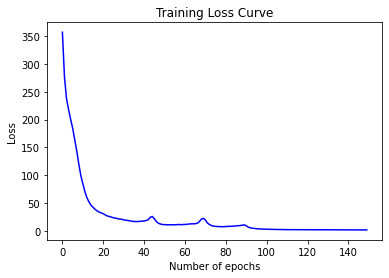

In [22]:
# Plot the results
fig = plt.figure()
plt.plot(np.arange(len(train_loss)), train_loss, color='b')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [23]:
model.to(device)
model.eval()

YOLO(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (transposed_conv7): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (transposed_conv8): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv9): Conv2d(64, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

5. Show a plot of the mean Average Precision over training for your model. (10%)

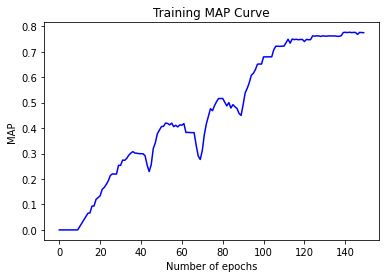

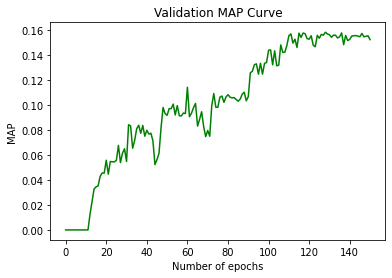

In [24]:
# Plot the results
fig = plt.figure()
plt.plot(np.arange(len(train_map)), train_map, color='b')
plt.xlabel('Number of epochs')
plt.ylabel('MAP')
plt.title('Training MAP Curve')
plt.show()

fig = plt.figure()
plt.plot(np.arange(len(validation_map)), validation_map, color='g')
plt.xlabel('Number of epochs')
plt.ylabel('MAP')
plt.title('Validation MAP Curve')
plt.show()

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

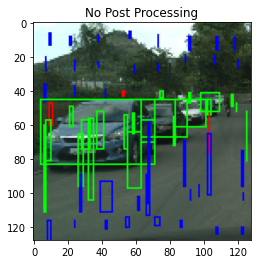

In [141]:
with torch.no_grad():
  for images, targets in test_loader:
    images = images.to(device)
    no_post_output = model(images)
    low_confidence_output = low_confidence_suppression(no_post_output)
    non_max_suppression_output = non_max_suppression(low_confidence_output)
    break

# visualize for image number 8 in batch
#print("In order to see full effects of non-max suppression, we changed the iou_threshold to 0.1. We will discuss this more in question 8.")
num = 26 #16

visualize_output(images[num], no_post_output[num], 'No Post Processing')

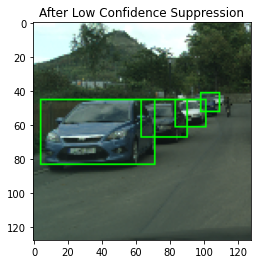

In [143]:
visualize_output(images[num], low_confidence_output[num], 'After Low Confidence Suppression')

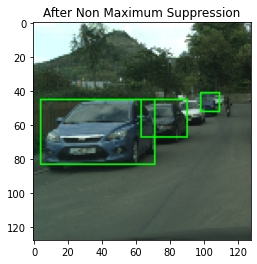

In [144]:
visualize_output(images[num], non_max_suppression_output[num], 'After Non Maximum Suppression')

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

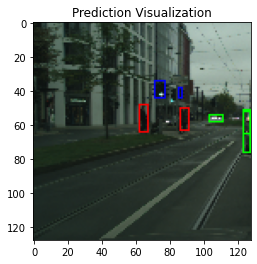

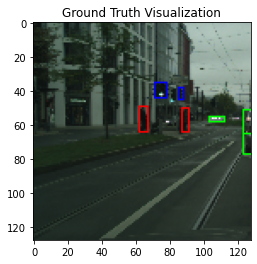

In [59]:
with torch.no_grad():
  for images, targets in test_loader:
    images = images.to(device)
    labels = model(images)
    labels = low_confidence_suppression(labels)
    labels = non_max_suppression(labels)
    break

# visualize for image number 63
num = 63
img = images[num]
output = labels[num]

visualize_output(img, output, 'Prediction Visualization')
visualize_output(img, targets[num], 'Ground Truth Visualization')


TRAINING CURVES


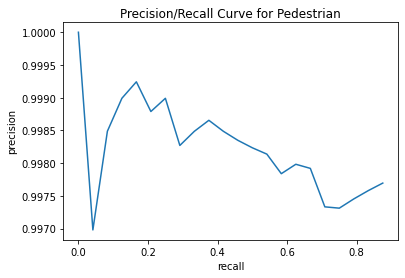

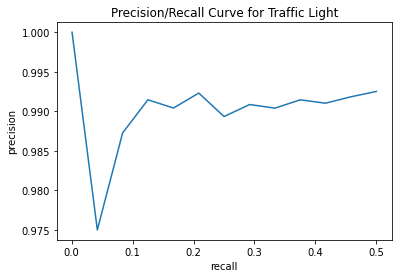

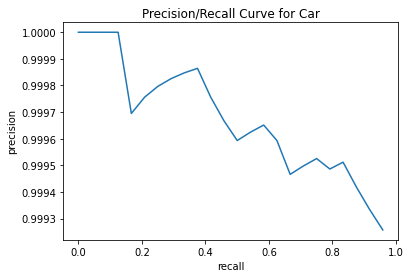

OUR TRAINING MAP:  0.7775858022722232


In [60]:
# precision, recall curves for training
print("TRAINING CURVES")
train_loader_precision_recall = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)
with torch.no_grad():
  for images, targets in train_loader_precision_recall:
    images = images.to(device)
    targets = targets.to(device)
    predictions = model(images)
    labels = low_confidence_suppression(predictions)
    labels = non_max_suppression(labels)

recall, precision = precision_recall_curve(labels, targets, target_class=0)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision/Recall Curve for Pedestrian')
plt.show()

recall, precision = precision_recall_curve(labels, targets, target_class=1)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision/Recall Curve for Traffic Light')
plt.show()

recall, precision = precision_recall_curve(labels, targets, target_class=2)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision/Recall Curve for Car')
plt.show()


map = mean_average_precision(labels, targets)
print("OUR TRAINING MAP: ", map)

INFERENCE CURVES


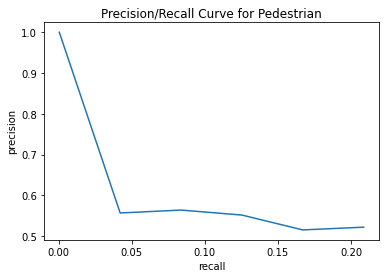

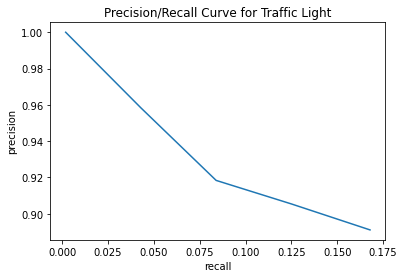

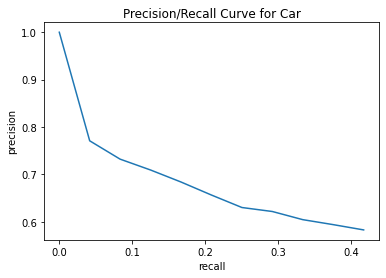

OUR INFERENCE MAP:  0.26883537952625297


In [114]:
# precision, recall curves for inference
print("INFERENCE CURVES")
test_loader_precision_recall = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
with torch.no_grad():
  for images, targets in test_loader_precision_recall:
    images = images.to(device)
    targets = targets.to(device)
    predictions = model(images)
    labels = low_confidence_suppression(predictions)
    labels = non_max_suppression(labels)

recall, precision = precision_recall_curve(labels, targets, target_class=0)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision/Recall Curve for Pedestrian')
plt.show()

recall, precision = precision_recall_curve(labels, targets, target_class=1)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision/Recall Curve for Traffic Light')
plt.show()

recall, precision = precision_recall_curve(labels, targets, target_class=2)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision/Recall Curve for Car')
plt.show()

map = mean_average_precision(labels, targets)
print("OUR INFERENCE MAP: ", map)


8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

**Issues and Challenges**
1. In the process labels function, we were given an input of (x1, y1, x2, y2) and had to process this into a 8x8x8 format. Initially, we represented the processed label grid indices as (x,y). Although this allowed us to pass the local autograder test, we realized that the heatmap visualizations of the channel did not match the image visualization. Hence, we indexed the processed label grid with (y,x). 

2. Additionally, in the process label function we had to extract one bounding box per grid cell. During this process, we were accidentally adding class information for boxes we were discarding, so some ground truth grid cells were assigned to multiple classes.

3. We implemented non maximum suppression by first adding the highest confidence box per class and then continuously adding boxes to a set of valid boxes if they were under the 0.6 threshold with other valid boxes. However, this implementation presented the following challenges. A low confidence suppression threshold of 0.6 removes a very large portion of the predicted boxes and does not leave enough boxes with overlaps to the remaining bounding boxes making non maximum suppression redundant.
This lead us to reducing the NMS IoU threshold value to 0.2, just for visualization purposes to verify that the function was working correctly and suppressing less confident boxes.

4. In order to find MAP, we sampled along different recall thresholds and found the corresponding precision. We did this by sorting the class confidences for a particular class and computing a rolling average of precision and recall. Once the rolling average recall surpasses a preset threshold, we plotted the recall value and its corresponding precision. 

5. During training, we wanted to use the training and validation MAP, with the latter providing a condition for early stopping. This calculation was initially being done over the batch, as we were computing this value in training_step and validation_step. However, taking the average of the MAP over all the batches is not a valid approach to finding the MAP over the entire training set or validation set. This is due to the fact that the approach mentioned above will weight the per batch MAP the same over all batches. This is clearly incorrect as the number of true positives, false positives, and false negatives will be different in each batch. Using the epoch_end functions allowed us to compute said values over the entire epoch and thus have a valid early stopping condition for network training.

**Model Performance:**

1. General : Training MAP = 0.778, Testing MAP = 0.269
2. Classwise :
  * Car: Training AP = 0.958, Testing AP = 0.422
  * Pedestrian: Training AP = 0.873, Testing AP = 0.259
  * Traffic Light: Training AP = 0.495, Testing AP = 0.159

- The training MAP is much higher compared to the testing MAP as expected. The traffic light has a much lower AP for the training set compared to the AP of the other classes. We believe this is directly correlated with the class imbalance present in this dataset. Extracting the class statistics showed us that there are just 2,834 traffic light instances, compared to the 15,887 pedestrian and 36,681 car instances. This also leads to the traffic light AP being so low in the testing set. Additionally, the image resolutions of 128 x 128 restricts the degree of learning of finer features, thus making the task of detecting and classifying traffic lights difficult.

- Training was intialized with a learning rate of 10e-3 as recommended. However during the later stages of training (around 70-90 epochs), the training loss and MAP would begin to get stuck in local minimums for long periods. To remedy this, we used a learning rate scheduler to decrease the learning rate to 10e-04 around the 70-90 epoch region to allow for continued reduction of training loss and better training MAP. 

- Ultimately, we achieved a low MAP on the training set, because the traffic light class' AP is much lower than the other 2 classes. Additionally, all classes had a low AP in the testing set, as the model proved to not be very generalizable. 

**Improvements:**

1. Class balancing with Data Augmentation : The performance could be improved by generating more examples of traffic light and pedestrian instances using scaling and translation techniques upto a certain percentage of the image size. This will lead to better class balance and allow the model to see enough examples from all classes. Another way of considering class imbalance could be to use a focal loss, which will weigh less frequently occurring classes more heavily. 

2. Model Architechture changes : 
* The model implemented is not the full YOLO model as described in the original paper. Our input images are already downsized to 128 x 128 and so this model will only ever learn coarse features. One technique to mitigate this would be to introduce upsampling layers to increase the image resolution, leading to better detection using finer features.
* The current model only allows one object per grid cell as an anchor. Increasing the number of possible anchors per grid cell will allow a better detection and classification of adjacent objects that are closer than the grid cell resolution.



## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [28]:
!sudo apt-get update &> /dev/null
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert --to pdf cis680_hw2.ipynb

[NbConvertApp] WARNING | pattern u'cis680_hw2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run nb

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [29]:
grader.check_all()

q1b results:
    q1b - 1 result:
        Trying:
            np.set_printoptions(precision=2)
        Expecting nothing
        ok
        Trying:
            for label in process_labels(raw_labels[0, np.newaxis])[0]:
                print(label)
        Expecting:
            [[0. 0. 0. 0. 0. 0. 0. 0.]
             [0. 0. 0. 0. 0. 0. 0. 0.]
             [0. 0. 0. 0. 0. 0. 0. 0.]
             [0. 0. 0. 0. 0. 0. 0. 0.]
             [0. 0. 0. 0. 0. 0. 0. 0.]
             [0. 0. 0. 1. 0. 0. 0. 0.]
             [0. 0. 0. 1. 0. 0. 0. 0.]
             [0. 0. 0. 1. 0. 0. 0. 0.]]
            [[0.   0.   0.   0.   0.   0.   0.   0.  ]
             [0.   0.   0.   0.   0.   0.   0.   0.  ]
             [0.   0.   0.   0.   0.   0.   0.   0.  ]
             [0.   0.   0.   0.   0.   0.   0.   0.  ]
             [0.   0.   0.   0.   0.   0.   0.   0.  ]
             [0.   0.   0.   0.47 0.   0.   0.   0.  ]
             [0.   0.   0.   0.59 0.   0.   0.   0.  ]
             [0.   0.   0.   0.56 0.